In [6]:
#created on Wed 2025.12.10
#created by Simon.H
import os
import shutil
import numpy as np
from sklearn.model_selection import train_test_split

from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, roc_auc_score
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc

import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision import models, transforms, datasets
import torch.nn.functional as F
import cv2
import random

In [7]:
origin_root = "/kaggle/input/covid-data/COVID-9 数据集和h5/COVID-19_Radiography_Dataset"
classes = ["COVID-19","NORMAL","Viral Pneumonia"]

root_dir = "/kaggle/working/COVID_split"


# automatic split 
if not os.path.exists(root_dir):
    os.makedirs(root_dir,exist_ok=True)

    for c in classes:
        img_path = os.path.join(origin_root,c)
        imgs = os.listdir(img_path)

        train, test = train_test_split(imgs, test_size=0.2, random_state=42)

        for split,files in [("train",train),("test",test)]:
            dst = os.path.join(root_dir,split,c)
            os.makedirs(dst,exist_ok=True)
            for f in files:
                shutil.copy(os.path.join(img_path,f), os.path.join(dst,f))

    print("Dataset prepared at:", root_dir)
else:
    print("Split exists at:", root_dir)

Split exists at: /kaggle/working/COVID_split


In [8]:
# transform 
train_tfms = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.ToTensor(),
])

test_tfms = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
])



# dataset
train_dataset = datasets.ImageFolder(os.path.join(root_dir, "train"), transform=train_tfms)
val_dataset   = datasets.ImageFolder(os.path.join(root_dir, "test"),  transform=test_tfms)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, num_workers=2)
val_loader   = DataLoader(val_dataset,   batch_size=16, shuffle=False, num_workers=2)

print("Classes:", train_dataset.classes)

Classes: ['COVID-19', 'NORMAL', 'Viral Pneumonia']


In [9]:
# CNN + MultiHead Attention
class CNN_ATT(nn.Module):
    def __init__(self, num_classes=3):
        super().__init__()

        self.cnn = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)
        self.cnn.fc = nn.Identity()                       

        self.att = nn.MultiheadAttention(embed_dim=512, num_heads=8, batch_first=True)

        self.fc = nn.Linear(512, num_classes)

    def forward(self, x):
        feat = self.cnn(x)         
        feat = feat.unsqueeze(1)   
        att_out,_ = self.att(feat, feat, feat)
        att_out = att_out.squeeze(1)
        return self.fc(att_out)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = CNN_ATT(num_classes=len(classes)).to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
criterion = nn.CrossEntropyLoss()

In [10]:
#  training
train_losses, val_losses = [], []

for epoch in range(20):
    model.train()
    train_loss=0
    
    for x,y in train_loader:
        x,y = x.to(device), y.to(device)
        optimizer.zero_grad()
        out = model(x)
        loss = criterion(out,y)
        loss.backward()
        optimizer.step()
        train_loss+=loss.item()
    
    train_loss/=len(train_loader)
    train_losses.append(train_loss)

    model.eval()
    val_loss=0
    with torch.no_grad():
        for x,y in val_loader:
            out = model(x.to(device))
            loss = criterion(out,y.to(device))
            val_loss+=loss.item()
    val_loss/=len(val_loader)
    val_losses.append(val_loss)

    print(f"Epoch {epoch+1} Train Loss {train_loss:.4f}  Val Loss {val_loss:.4f}")

Epoch 1 Train Loss 0.1988  Val Loss 0.0998
Epoch 2 Train Loss 0.1087  Val Loss 0.1685
Epoch 3 Train Loss 0.0876  Val Loss 0.0719
Epoch 4 Train Loss 0.0697  Val Loss 0.0408
Epoch 5 Train Loss 0.0639  Val Loss 0.0364
Epoch 6 Train Loss 0.0538  Val Loss 0.0482
Epoch 7 Train Loss 0.0531  Val Loss 0.0614
Epoch 8 Train Loss 0.0461  Val Loss 0.0426
Epoch 9 Train Loss 0.0438  Val Loss 0.0383
Epoch 10 Train Loss 0.0410  Val Loss 0.0618
Epoch 11 Train Loss 0.0369  Val Loss 0.0490
Epoch 12 Train Loss 0.0287  Val Loss 0.0423
Epoch 13 Train Loss 0.0348  Val Loss 0.0309
Epoch 14 Train Loss 0.0317  Val Loss 0.0348
Epoch 15 Train Loss 0.0225  Val Loss 0.0383
Epoch 16 Train Loss 0.0288  Val Loss 0.0348
Epoch 17 Train Loss 0.0289  Val Loss 0.0585
Epoch 18 Train Loss 0.0193  Val Loss 0.0420
Epoch 19 Train Loss 0.0283  Val Loss 0.0620
Epoch 20 Train Loss 0.0232  Val Loss 0.0572


In [11]:
#  evaluation
y_true=[]
y_pred=[]
y_score=[]

model.eval()
with torch.no_grad():
    for x,y in val_loader:
        prob = F.softmax(model(x.to(device)),dim=1)
        y_pred.extend(prob.argmax(1).cpu().numpy())
        y_true.extend(y.numpy())
        y_score.extend(prob.cpu().numpy())


# confusion matrix
cm = confusion_matrix(y_true,y_pred)
print("Confusion Matrix:")
print(cm)


# classification report
print("\nClassification Report:\n",
      classification_report(y_true,y_pred,target_names=classes))


# numeric metrics
acc  = accuracy_score(y_true,y_pred)
prec = precision_score(y_true,y_pred,average='macro')
rec  = recall_score(y_true,y_pred,average='macro')
f1   = f1_score(y_true,y_pred,average='macro')

print("\nAccuracy",acc)
print("Precision",prec)
print("Recall",rec)
print("F1",f1)

Confusion Matrix:
[[ 723    1    0]
 [  45 1976   18]
 [   1    2  266]]

Classification Report:
                  precision    recall  f1-score   support

       COVID-19       0.94      1.00      0.97       724
         NORMAL       1.00      0.97      0.98      2039
Viral Pneumonia       0.94      0.99      0.96       269

       accuracy                           0.98      3032
      macro avg       0.96      0.99      0.97      3032
   weighted avg       0.98      0.98      0.98      3032


Accuracy 0.9779023746701847
Precision 0.9584286185987935
Recall 0.9855229564665335
F1 0.9713729975674239


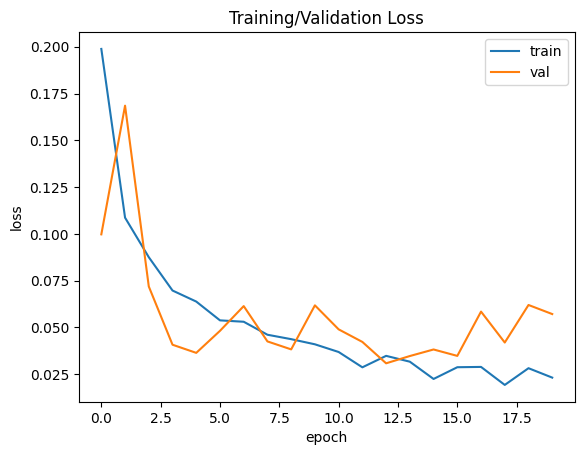

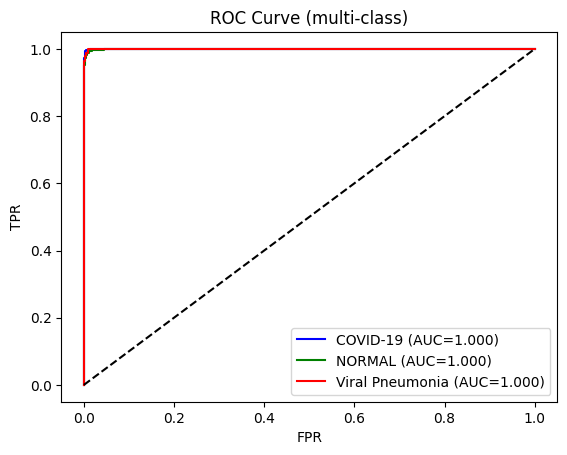

In [12]:
# loss curve
plt.figure()
plt.plot(train_losses,label='train')
plt.plot(val_losses,label='val')
plt.legend()
plt.xlabel("epoch")
plt.ylabel("loss")
plt.title("Training/Validation Loss")
plt.show()



#  ROC-AUC multi-class
y_true_bin = label_binarize(y_true, classes=list(range(len(classes))))
y_score = np.array(y_score)

fpr,tpr,roc_auc={}, {},{}
colors=["b","g","r"]

for i in range(len(classes)):
    fpr[i],tpr[i],_=roc_curve(y_true_bin[:,i],y_score[:,i])
    roc_auc[i]=auc(fpr[i],tpr[i])

plt.figure()
for i,color in zip(range(len(classes)),colors):
    plt.plot(fpr[i],tpr[i],color=color,
        label=f"{classes[i]} (AUC={roc_auc[i]:.3f})")
plt.plot([0,1],[0,1],"k--")
plt.legend()
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title("ROC Curve (multi-class)")
plt.show()

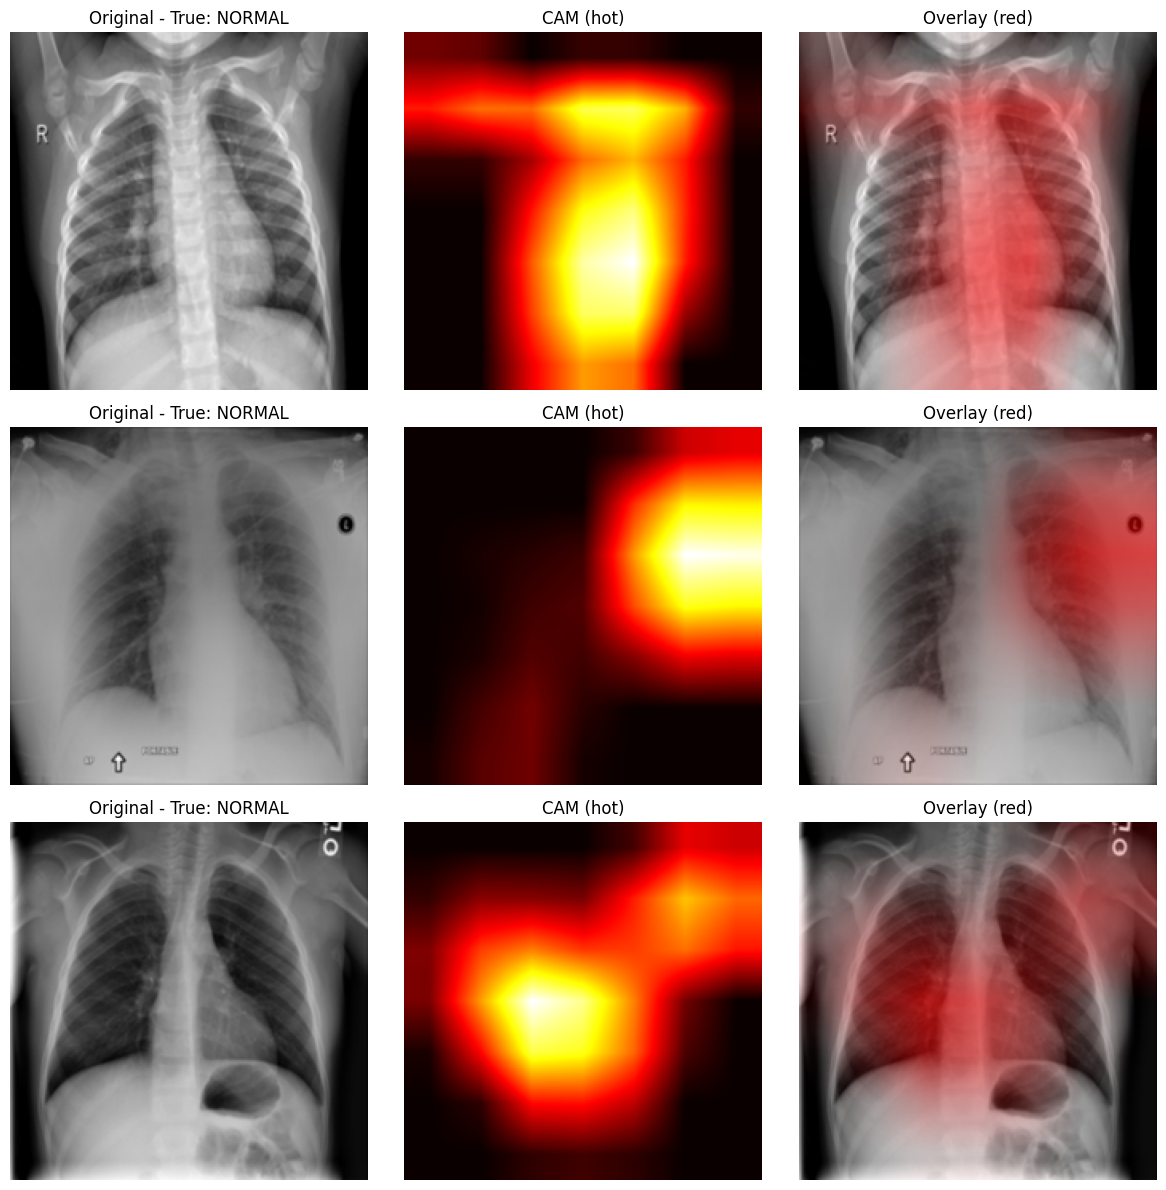

In [13]:
# show red heatmap and show 3 samples

class GradCAM:
    def __init__(self, model, target_module):
        self.model = model
        self.model.eval()
        self.target_module = target_module

        self.gradients = None
        self.activations = None
     
        def _forward_hook(module, input, output):
            self.activations = output.detach()

        def _backward_hook(module, grad_input, grad_output):
            self.gradients = grad_output[0].detach()

        self.fh = self.target_module.register_forward_hook(_forward_hook)
        try:
            self.bh = self.target_module.register_full_backward_hook(_backward_hook)
        except:
            self.bh = self.target_module.register_backward_hook(_backward_hook)

    def generate_cam(self, input_tensor, class_idx=None):
        device = next(self.model.parameters()).device
        
        input_tensor = input_tensor.to(device)
        output = self.model(input_tensor)  # shape (1, num_classes)
        if class_idx is None:
            class_idx = int(output.argmax(dim=1).item())

        self.model.zero_grad()
 
        loss = output[0, class_idx]
        loss.backward(retain_graph=False)

        activations = self.activations.squeeze(0).cpu().numpy()   
        gradients = self.gradients.squeeze(0).cpu().numpy()      

        weights = np.mean(gradients, axis=(1,2))                  

        cam = np.zeros(activations.shape[1:], dtype=np.float32)   
        for i, w in enumerate(weights):
            cam += w * activations[i, :, :]

        cam = np.maximum(cam, 0)
        if np.max(cam) == 0:
            return np.zeros_like(cam)
        cam = cam - np.min(cam)
        cam = cam / np.max(cam)
        return cam

    def remove_hooks(self):
        self.fh.remove()
        try:
            self.bh.remove()
        except:
            pass

target_layer = model.cnn.layer4[-1].conv2
cam_generator = GradCAM(model, target_layer)

num_show = 3
indices = random.sample(range(len(val_dataset)), k=num_show)

plt.figure(figsize=(12,4*num_show))
for i, idx in enumerate(indices):
    img_tensor, label = val_dataset[idx]           
    input_tensor = img_tensor.unsqueeze(0).to(device)  

    model.eval()
    cam_map = cam_generator.generate_cam(input_tensor, class_idx=None)  

    h, w = img_tensor.shape[1], img_tensor.shape[2]
    cam_resized = cv2.resize(cam_map, (w, h))
    cam_resized = np.clip(cam_resized, 0, 1)

    img_np = img_tensor.permute(1,2,0).cpu().numpy()   
    img_uint8 = np.uint8(255 * img_np)
    if img_uint8.ndim == 2:
        img_uint8 = cv2.cvtColor(img_uint8, cv2.COLOR_GRAY2RGB)

    alpha = 0.6  
    heat = np.expand_dims(cam_resized, axis=2)  
    red_layer = np.zeros_like(img_uint8, dtype=np.uint8)
    red_layer[..., 0] = 255  
    red_layer[..., 1] = 0
    red_layer[..., 2] = 0

    overlay = img_uint8.astype(np.float32) * (1 - alpha * heat) + red_layer.astype(np.float32) * (alpha * heat)
    overlay = np.clip(overlay, 0, 255).astype(np.uint8)

    plt.subplot(num_show, 3, i*3 + 1)
    plt.imshow(img_uint8)
    plt.title(f"Original - True: {classes[label]}")
    plt.axis("off")

    plt.subplot(num_show, 3, i*3 + 2)
    plt.imshow(cam_resized, cmap='hot')
    plt.title("CAM (hot)")
    plt.axis("off")

    plt.subplot(num_show, 3, i*3 + 3)
    plt.imshow(overlay)
    plt.title("Overlay (red)")
    plt.axis("off")

plt.tight_layout()
plt.show()

cam_generator.remove_hooks()